In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


### My key


In [15]:
CLIENT_ID = 'QEF4SFROUUVOQKNPAFNNRDUW4ACAWSYYG312LM3BKEDDKPIZ' # your Foursquare ID
CLIENT_SECRET = 'CCBFW1WDVTUYDLPFX3SR0QBB5R2UKRYOZ3F1JDJ3PLQMPDRM' # your Foursquare Secret
VERSION = '20180604'


### Function

In [16]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

### NYC data

In [17]:

ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [18]:
ny_data.shape


(306, 4)

### Exploratory Data Analysis

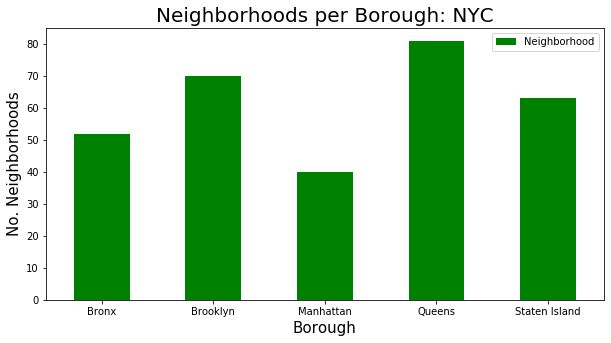

In [19]:
clr = "green"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()


### Let's analyze further and see how many Chinese restaurants there are in each neighborhood and borough. After it, graph the results

In [26]:

# queens has most neighborhoods
# prepare neighborhood list that contains Chinese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_restaurants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(ny_data),')','Chinese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(Chinese_restaurants)))
    print(row)
    for resturant_detail in chinese_restaurants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)

( 1 / 306 ) Chinese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 1 / 306 ) Chinese Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 1 / 306 ) Chinese Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 1 / 306 ) Chinese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 1 / 306 ) Chinese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 1 / 306 ) Chinese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 1 / 306 ) Chinese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 1 / 306 ) Chinese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 1 / 306 ) Chinese Restaurants in Norwood, Bronx:0
['

( 1 / 306 ) Chinese Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 1 / 306 ) Chinese Restaurants in Gowanus, Brooklyn:0
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 1 / 306 ) Chinese Restaurants in Fort Greene, Brooklyn:0
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 1 / 306 ) Chinese Restaurants in Park Slope, Brooklyn:0
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 1 / 306 ) Chinese Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 1 / 306 ) Chinese Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 1 / 306 ) Chinese Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 1 / 306 ) Chinese Restaurants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]


( 1 / 306 ) Chinese Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 1 / 306 ) Chinese Restaurants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 1 / 306 ) Chinese Restaurants in Howard Beach, Queens:0
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 1 / 306 ) Chinese Restaurants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 1 / 306 ) Chinese Restaurants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 1 / 306 ) Chinese Restaurants in Kew Gardens, Queens:0
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 1 / 306 ) Chinese Restaurants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 1 / 306 ) Chinese Restaurants in Flushing, Queens:0
['Queens', 'Flushing', 40.76445419697846, -73.83177300329582]
( 1 / 306 ) Chinese Restaurants

KeyError: 'groups'

In [25]:
chinese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Co-op City,4c9d5f2654c8a1cd2e71834b,Guang Hui Chinese Restaurant
1,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant
2,Bronx,Norwood,4e41d2c4b61ca5ba3b1f9c6b,Ming Liang Kitchen
3,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant
4,Bronx,Bedford Park,4e4d0387bd413c4cc66dfd72,Hung Hing Chinese Restaurant


In [27]:
chinese_rest_ny.shape


(134, 4)

In [32]:
df_c =pd.read_csv('chinese_rest.csv', index_col=0)

In [33]:
df_c.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Co-op City,4c9d5f2654c8a1cd2e71834b,Guang Hui Chinese Restaurant
1,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant
2,Bronx,Norwood,4e41d2c4b61ca5ba3b1f9c6b,Ming Liang Kitchen
3,Bronx,Pelham Parkway,4b9d6b45f964a52078ab36e3,Mr. Q's Chinese Restaurant
4,Bronx,Bedford Park,4e4d0387bd413c4cc66dfd72,Hung Hing Chinese Restaurant


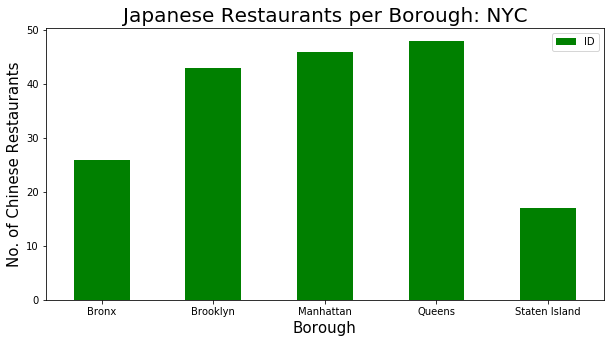

In [35]:
df_c.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Chinese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

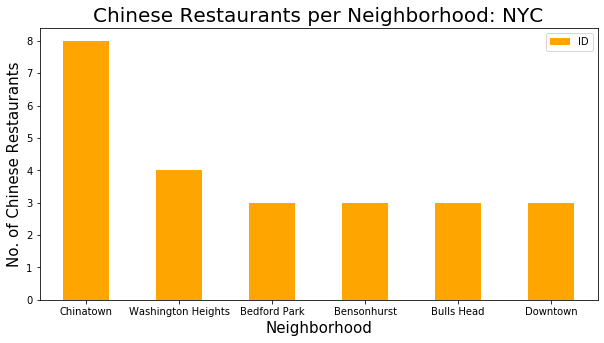

In [40]:
NOofNeigh = 6 # top number for graphing all the same past 6
df_c.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color= 'orange')
plt.title('Chinese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Chinese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [41]:
df_c[df_c['Neighborhood']=='Chinatown']

,Borough,Neighborhood,ID,Name
54,Manhattan,Chinatown,4db3374590a0843f295fb69b,Spicy Village
55,Manhattan,Chinatown,4a96bf8ff964a520ce2620e3,Wah Fung Number 1 Fast Food 華豐快餐店
56,Manhattan,Chinatown,5894c9a15e56b417cf79e553,Xi'an Famous Foods
57,Manhattan,Chinatown,5c965dad5455b2002c058659,Yi Ji Shi Mo Noodle Corp
58,Manhattan,Chinatown,59d828f0916bc1155fde2c04,Hwa Yuan
59,Manhattan,Chinatown,3fd66200f964a520b1ea1ee3,Great N.Y. Noodletown
60,Manhattan,Chinatown,59ad625a2619ee5cdded881f,House Special 甘來飯店
61,Manhattan,Chinatown,3fd66200f964a520ede41ee3,Big Wong King 大旺


So the Chinatown in Manhattan has the highest number of chinese Restaurants with a total count of 8.

Now we will get the ranking of each restaurant for further analysis.

In [42]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in df_c.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(df_c),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1


{'meta': {'code': 200, 'requestId': '5fc9547b2aa0530e5a1cbf90'}, 'response': {'venue': {'id': '4c9d5f2654c8a1cd2e71834b', 'name': 'Guang Hui Chinese Restaurant', 'contact': {'phone': '7188623288', 'formattedPhone': '(718) 862-3288'}, 'location': {'address': '125 Dreiser Loop', 'lat': 40.876651, 'lng': -73.829092, 'labeledLatLngs': [{'label': 'display', 'lat': 40.876651, 'lng': -73.829092}, {'label': 'entrance', 'lat': 40.876084, 'lng': -73.829209}], 'postalCode': '10475', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['125 Dreiser Loop', 'Bronx, NY 10475', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/guang-hui-chinese-restaurant/4c9d5f2654c8a1cd2e71834b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'st

{'meta': {'code': 200, 'requestId': '5fc9547bdffa6f58c5b95bee'}, 'response': {'venue': {'id': '4e41d2c4b61ca5ba3b1f9c6b', 'name': 'Ming Liang Kitchen', 'contact': {'phone': '71854707780779', 'formattedPhone': '71854707780779'}, 'location': {'address': '236 E Gun Hill Rd', 'crossStreet': 'Kings College Place', 'lat': 40.879876, 'lng': -73.87662900000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.879876, 'lng': -73.87662900000001}, {'label': 'entrance', 'lat': 40.879844, 'lng': -73.87664}], 'postalCode': '10467', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['236 E Gun Hill Rd (Kings College Place)', 'Bronx, NY 10467', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ming-liang-kitchen/4e41d2c4b61ca5ba3b1f9c6b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',

{'meta': {'code': 200, 'requestId': '5fc9547c27dc4e1dbbadcda0'}, 'response': {'venue': {'id': '4e4d0387bd413c4cc66dfd72', 'name': 'Hung Hing Chinese Restaurant', 'contact': {'phone': '7185625050', 'formattedPhone': '(718) 562-5050'}, 'location': {'address': '239 Bedford Park Blvd', 'lat': 40.871181206606806, 'lng': -73.88675855253665, 'labeledLatLngs': [{'label': 'display', 'lat': 40.871181206606806, 'lng': -73.88675855253665}, {'label': 'entrance', 'lat': 40.871189, 'lng': -73.886476}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['239 Bedford Park Blvd', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hung-hing-chinese-restaurant/4e4d0387bd413c4cc66dfd72', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'

{'meta': {'code': 200, 'requestId': '5fc9547d85adf10fc1aadf97'}, 'response': {'venue': {'id': '4cf30a837e93f04d366a5669', 'name': 'China Wok II', 'contact': {'phone': '7185842488', 'formattedPhone': '(718) 584-2488'}, 'location': {'address': '2459 Webster Ave', 'crossStreet': '188th street', 'lat': 40.860219, 'lng': -73.893323, 'labeledLatLngs': [{'label': 'display', 'lat': 40.860219, 'lng': -73.893323}, {'label': 'entrance', 'lat': 40.860154, 'lng': -73.893174}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2459 Webster Ave (188th street)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/china-wok-ii/4cf30a837e93f04d366a5669', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verifie

{'meta': {'code': 200, 'requestId': '5fc9547ef5ceae3a1202dd68'}, 'response': {'venue': {'id': '4cd88b521891236a79d8360b', 'name': 'Hong Kong', 'contact': {'phone': '7187920219', 'formattedPhone': '(718) 792-0219'}, 'location': {'address': '459 Morris Park Ave', 'lat': 40.8408088684082, 'lng': -73.87335205078125, 'labeledLatLngs': [{'label': 'entrance', 'lat': 40.840752, 'lng': -73.873093}, {'label': 'display', 'lat': 40.8408088684082, 'lng': -73.87335205078125}], 'postalCode': '10460', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['459 Morris Park Ave', 'Bronx, NY 10460', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hong-kong/4cd88b521891236a79d8360b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stat

{'meta': {'code': 200, 'requestId': '5fc9547fdffa6f58c5b969d2'}, 'response': {'venue': {'id': '4cfece683f846dcb83408d37', 'name': 'Great Wall Chinese Food', 'contact': {'phone': '7188424075', 'formattedPhone': '(718) 842-4075', 'twitter': 'thegreatwallma'}, 'location': {'address': '991 Prospect Ave', 'lat': 40.823273182797735, 'lng': -73.90004240721701, 'labeledLatLngs': [{'label': 'display', 'lat': 40.823273182797735, 'lng': -73.90004240721701}, {'label': 'entrance', 'lat': 40.823287, 'lng': -73.900314}], 'postalCode': '10459', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['991 Prospect Ave', 'Bronx, NY 10459', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-wall-chinese-food/4cfece683f846dcb83408d37', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix

{'meta': {'code': 200, 'requestId': '5fc9548076cc650db8d606f8'}, 'response': {'venue': {'id': '4b89b62df964a520ff4c32e3', 'name': 'Sabor Latino Seafood Restaurant', 'contact': {'phone': '7188220899', 'formattedPhone': '(718) 822-0899'}, 'location': {'address': '2161 Starling Ave', 'crossStreet': 'at Purdy St', 'lat': 40.83636550185743, 'lng': -73.85303360278897, 'labeledLatLngs': [{'label': 'display', 'lat': 40.83636550185743, 'lng': -73.85303360278897}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2161 Starling Ave (at Purdy St)', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sabor-latino-seafood-restaurant/4b89b62df964a520ff4c32e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}]

{'meta': {'code': 200, 'requestId': '5fc95480dea0816c869dc227'}, 'response': {'venue': {'id': '4dcdb39352b1f8915b842d57', 'name': 'Joy Garden', 'contact': {'phone': '7185181242', 'formattedPhone': '(718) 518-1242'}, 'location': {'address': '687 Morris Park Ave', 'crossStreet': 'White Plains Rd', 'lat': 40.845357, 'lng': -73.866567, 'labeledLatLngs': [{'label': 'display', 'lat': 40.845357, 'lng': -73.866567}, {'label': 'entrance', 'lat': 40.845284, 'lng': -73.866512}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['687 Morris Park Ave (White Plains Rd)', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joy-garden/4dcdb39352b1f8915b842d57', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 

{'meta': {'code': 200, 'requestId': '5fc954816ef0be321d8f1cb3'}, 'response': {'venue': {'id': '4e4dd9bcbd4101d0d79cbeb3', 'name': 'King Hing', 'contact': {'phone': '7182397723', 'formattedPhone': '(718) 239-7723'}, 'location': {'address': '3227 Westchester Ave', 'lat': 40.852266, 'lng': -73.829225, 'labeledLatLngs': [{'label': 'display', 'lat': 40.852266, 'lng': -73.829225}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3227 Westchester Ave', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/king-hing/4e4dd9bcbd4101d0d79cbeb3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'hasMenu

{'meta': {'code': 200, 'requestId': '5fc95482e915b64c931891fe'}, 'response': {'venue': {'id': '4e4cd93fbd413c4cc66ca721', 'name': 'Great Wall Restaurant', 'contact': {'phone': '7188373311', 'formattedPhone': '(718) 837-3311', 'twitter': 'thegreatwallma'}, 'location': {'address': '7614 18th Ave', 'lat': 40.612788, 'lng': -73.99699100000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.612788, 'lng': -73.99699100000001}, {'label': 'entrance', 'lat': 40.612647, 'lng': -73.996913}], 'postalCode': '11214', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['7614 18th Ave', 'Brooklyn, NY 11214', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-wall-restaurant/4e4cd93fbd413c4cc66ca721', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary':

{'meta': {'code': 200, 'requestId': '5fc954836ef0be321d8f24b8'}, 'response': {'venue': {'id': '4c9257fe7088a143c59fb843', 'name': 'Dragon Garden', 'contact': {'phone': '7182348288', 'formattedPhone': '(718) 234-8288'}, 'location': {'address': '8024 18th Ave', 'lat': 40.61029, 'lng': -73.999592, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61029, 'lng': -73.999592}, {'label': 'entrance', 'lat': 40.610116, 'lng': -73.999472}], 'postalCode': '11214', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8024 18th Ave', 'Brooklyn, NY 11214', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dragon-garden/4c9257fe7088a143c59fb843', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': 

{'meta': {'code': 200, 'requestId': '5fc95484e02006393a3b60b1'}, 'response': {'venue': {'id': '4abd867df964a520d78a20e3', 'name': 'Shang Hai Lee', 'contact': {'phone': '7183496716', 'formattedPhone': '(718) 349-6716'}, 'location': {'address': '157 Franklin St', 'crossStreet': 'India & Java', 'lat': 40.731829236676546, 'lng': -73.95784627979856, 'labeledLatLngs': [{'label': 'display', 'lat': 40.731829236676546, 'lng': -73.95784627979856}], 'postalCode': '11222', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['157 Franklin St (India & Java)', 'Brooklyn, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shang-hai-lee/4abd867df964a520d78a20e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': 

{'meta': {'code': 200, 'requestId': '5fc954855b23bb2330ddf52f'}, 'response': {'venue': {'id': '4d91f9a1d7b1236a6e343c38', 'name': 'Golden chopsticks', 'contact': {'phone': '7183758340', 'formattedPhone': '(718) 375-8340'}, 'location': {'address': '1986-88 Ocean Ave', 'lat': 40.61322, 'lng': -73.95387, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61322, 'lng': -73.95387}], 'postalCode': '11230', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1986-88 Ocean Ave', 'Brooklyn, NY 11230', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-chopsticks/4d91f9a1d7b1236a6e343c38', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$

{'meta': {'code': 200, 'requestId': '5fc9548631a5a81caca35298'}, 'response': {'venue': {'id': '54e39b14498e9c646b42958e', 'name': 'East Wind Snack Shop', 'contact': {'phone': '9292950188', 'formattedPhone': '(929) 295-0188'}, 'location': {'address': '471 16th St', 'crossStreet': 'at Prospect Park West', 'lat': 40.660297, 'lng': -73.980169, 'labeledLatLngs': [{'label': 'display', 'lat': 40.660297, 'lng': -73.980169}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['471 16th St (at Prospect Park West)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/east-wind-snack-shop/54e39b14498e9c646b42958e', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount

{'meta': {'code': 200, 'requestId': '5fc95487e749390203ac4cf2'}, 'response': {'venue': {'id': '4c06e2470e0a2d7fdf8aec0c', 'name': '#1 Garden Chinese Food', 'contact': {'phone': '7188321795', 'formattedPhone': '(718) 832-1795'}, 'location': {'address': '221 Prospect Park W', 'lat': 40.660248811093595, 'lng': -73.98054235147856, 'labeledLatLngs': [{'label': 'display', 'lat': 40.660248811093595, 'lng': -73.98054235147856}, {'label': 'entrance', 'lat': 40.660106, 'lng': -73.980445}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['221 Prospect Park W', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/1-garden-chinese-food/4c06e2470e0a2d7fdf8aec0c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary

{'meta': {'code': 200, 'requestId': '5fc95488fd895d01ae265f13'}, 'response': {'venue': {'id': '4a9ac078f964a5207c3220e3', 'name': 'Fortune House', 'contact': {'phone': '7188557055', 'formattedPhone': '(718) 855-7055'}, 'location': {'address': '82 Henry St', 'crossStreet': 'btwn Pineapple & Orange St', 'lat': 40.698411434008214, 'lng': -73.99254201285272, 'labeledLatLngs': [{'label': 'display', 'lat': 40.698411434008214, 'lng': -73.99254201285272}, {'label': 'entrance', 'lat': 40.69842, 'lng': -73.992688}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['82 Henry St (btwn Pineapple & Orange St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fortune-house/4a9ac078f964a5207c3220e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/f

{'meta': {'code': 200, 'requestId': '5fc95488dffa6f58c5b98b41'}, 'response': {'venue': {'id': '4a986a9cf964a520e82b20e3', 'name': 'Great Wall Chinese Food', 'contact': {'phone': '7188552630', 'formattedPhone': '(718) 855-2630'}, 'location': {'address': '60 Henry St', 'crossStreet': 'btw Cranberry St and Orange St', 'lat': 40.698983696296274, 'lng': -73.99218529980111, 'labeledLatLngs': [{'label': 'display', 'lat': 40.698983696296274, 'lng': -73.99218529980111}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['60 Henry St (btw Cranberry St and Orange St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-wall-chinese-food/4a986a9cf964a520e82b20e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '5fc95489a5b71d40e915dc77'}, 'response': {'venue': {'id': '4c60a7cede6920a15f9d9664', 'name': "Michael and Ping's", 'contact': {'phone': '7187880017', 'formattedPhone': '(718) 788-0017', 'facebook': '107321149195', 'facebookUsername': 'michaelandpings', 'facebookName': "Michael & Ping's - Modern Chinese Take-out"}, 'location': {'address': '437 3rd Ave', 'crossStreet': 'btwn 7th & 8th St.', 'lat': 40.67216239483681, 'lng': -73.99037941409061, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67216239483681, 'lng': -73.99037941409061}, {'label': 'entrance', 'lat': 40.67216, 'lng': -73.990273}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['437 3rd Ave (btwn 7th & 8th St.)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/michael-and-pings/4c60a7cede6920a15f9d9664', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', '

{'meta': {'code': 200, 'requestId': '5fc95489fd895d01ae26658c'}, 'response': {'venue': {'id': '49bb541ff964a520e3531fe3', 'name': 'Hunan Delight', 'contact': {'phone': '7187891400', 'formattedPhone': '(718) 789-1400'}, 'location': {'address': '752 Union St', 'crossStreet': 'b/t 5th and 6th ave', 'lat': 40.67546106658002, 'lng': -73.97804145177376, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67546106658002, 'lng': -73.97804145177376}, {'label': 'entrance', 'lat': 40.675398, 'lng': -73.978171}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['752 Union St (b/t 5th and 6th ave)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hunan-delight/49bb541ff964a520e3531fe3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 

{'meta': {'code': 200, 'requestId': '5fc9548a37f45509dfad3f8f'}, 'response': {'venue': {'id': '4c818737d8086dcb1c0f6e52', 'name': 'Wah On', 'contact': {'phone': '7183481730', 'formattedPhone': '(718) 348-1730'}, 'location': {'address': '986 Sutter Ave', 'crossStreet': 'Linwood', 'lat': 40.671129, 'lng': -73.882306, 'labeledLatLngs': [{'label': 'display', 'lat': 40.671129, 'lng': -73.882306}, {'label': 'entrance', 'lat': 40.67119, 'lng': -73.882322}], 'postalCode': '11208', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['986 Sutter Ave (Linwood)', 'Brooklyn, NY 11208', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wah-on/4c818737d8086dcb1c0f6e52', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {

{'meta': {'code': 200, 'requestId': '5fc9548b79c81d6dc19c3b22'}, 'response': {'venue': {'id': '4c5075d73940be9ae2124a07', 'name': 'new grand wok', 'contact': {'phone': '7186451993', 'formattedPhone': '(718) 645-1993'}, 'location': {'address': '3510 Avenue S', 'lat': 40.609311, 'lng': -73.931668, 'labeledLatLngs': [{'label': 'display', 'lat': 40.609311, 'lng': -73.931668}, {'label': 'entrance', 'lat': 40.609357, 'lng': -73.931719}], 'postalCode': '11234', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3510 Avenue S', 'Brooklyn, NY 11234', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/new-grand-wok/4c5075d73940be9ae2124a07', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price'

{'meta': {'code': 200, 'requestId': '5fc9548bb1c42f0105d3778e'}, 'response': {'venue': {'id': '59da9590e1f0aa52976b8f35', 'name': 'Han Dynasty', 'contact': {}, 'location': {'address': '445 Albee Sq', 'crossStreet': 'Fleet St', 'lat': 40.691333919005594, 'lng': -73.98245632424464, 'labeledLatLngs': [{'label': 'display', 'lat': 40.691333919005594, 'lng': -73.98245632424464}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['445 Albee Sq (Fleet St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/han-dynasty/59da9590e1f0aa52976b8f35', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'short

{'meta': {'code': 200, 'requestId': '5fc9548cb1c42f0105d378e7'}, 'response': {'venue': {'id': '5db3649a8d15ba00089b4e9b', 'name': "Xi'an Famous Foods", 'contact': {}, 'location': {'address': '54 Willoughby St', 'lat': 40.69217, 'lng': -73.98673, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69217, 'lng': -73.98673}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['54 Willoughby St', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xian-famous-foods/5db3649a8d15ba00089b4e9b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 9, 'groups': [{'type': 'others', 'c

{'meta': {'code': 200, 'requestId': '5fc9548de208c61b160f44fa'}, 'response': {'venue': {'id': '585d72449f25836f2b2b7a1b', 'name': 'Xifu Food', 'contact': {'phone': '7182378886', 'formattedPhone': '(718) 237-8886'}, 'location': {'address': '318 Livingston St', 'lat': 40.688027, 'lng': -73.982088, 'labeledLatLngs': [{'label': 'display', 'lat': 40.688027, 'lng': -73.982088}, {'label': 'entrance', 'lat': 40.688057, 'lng': -73.982014}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['318 Livingston St', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xifu-food/585d72449f25836f2b2b7a1b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735', 'name': 'Dumpling 

{'meta': {'code': 200, 'requestId': '5fc9548da5b71d40e915ea80'}, 'response': {'venue': {'id': '4f4464ed19836ed00193d4a6', 'name': 'Good Taste Chinese Restaurant', 'contact': {'phone': '7184856868', 'formattedPhone': '(718) 485-6868'}, 'location': {'address': '126 Hull St', 'lat': 40.679237, 'lng': -73.910843, 'labeledLatLngs': [{'label': 'display', 'lat': 40.679237, 'lng': -73.910843}, {'label': 'entrance', 'lat': 40.679221, 'lng': -73.9109}], 'postalCode': '11233', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['126 Hull St', 'Brooklyn, NY 11233', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/good-taste-chinese-restaurant/4f4464ed19836ed00193d4a6', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats'

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5fc9548edffa6f58c5b99f47'}, 'response': {}}


KeyError: 'venue'

In [43]:
chinese_rest_stats_ny.tail()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
45,Brooklyn,Downtown,5db3649a8d15ba00089b4e9b,Xi'an Famous Foods,9,8.8,3
46,Brooklyn,Downtown,585d72449f25836f2b2b7a1b,Xifu Food,28,8.1,13
47,Brooklyn,Boerum Hill,585d72449f25836f2b2b7a1b,Xifu Food,28,8.1,13
48,Brooklyn,Ocean Hill,0,0,0,0,0
49,Brooklyn,North Side,58df00318cfe546addb99246,Birds of a Feather,352,9,75


In [79]:
chinese_rest_stats_ny.to_csv('chinese_rest2.csv') # As I move through this project I continue to save data to a .csv file

In [44]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       50 non-null     object
 1   Neighborhood  50 non-null     object
 2   ID            50 non-null     object
 3   Name          50 non-null     object
 4   Likes         50 non-null     object
 5   Rating        50 non-null     object
 6   Tips          50 non-null     object
dtypes: object(7)
memory usage: 2.9+ KB


In [48]:
chinese_rest_stats_ny['Likes'] = chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips'] = chinese_rest_stats_ny['Tips'].astype('float64')
chinese_rest_stats_ny['Rating'] = chinese_rest_stats_ny['Rating'].astype('float64')
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [49]:
chinese_rest_stats_ny.describe()

,Likes,Rating,Tips
count,50.000000,50.00000,50.000000
mean,20.740000,3.25800,8.220000
std,58.948892,3.64832,17.386706
min,0.000000,0.00000,0.000000
25%,0.000000,0.00000,0.000000
50%,0.000000,0.00000,0.000000
75%,6.000000,6.65000,7.250000
max,352.000000,9.00000,77.000000


In [52]:

# Resturant with maximum Likes
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                  North Side
ID              58df00318cfe546addb99246
Name                  Birds of a Feather
Likes                                352
Rating                                 9
Tips                                  75
Name: 49, dtype: object

In [53]:
# Resturant with maximum Ratings
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood             Windsor Terrace
ID              54e39b14498e9c646b42958e
Name                East Wind Snack Shop
Likes                                142
Rating                                 9
Tips                                  50
Name: 31, dtype: object

In [55]:
# Resturant with maximum Tips
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood                Clinton Hill
ID              4a71ff01f964a52016da1fe3
Name                             Kum Kau
Likes                                109
Rating                               7.9
Tips                                  77
Name: 43, dtype: object

### Now let's identify and visualize neighborhood with the maximum average rating of restaurants

In [70]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
25,North Side,9.00
11,Downtown,8.50
3,Boerum Hill,8.10
7,Clinton Hill,7.90
31,Pelham Parkway,7.60
9,Concourse,7.60
37,Windsor Terrace,7.45
0,Bay Ridge,7.30
28,Park Slope,7.20
15,Eastchester,6.70



Above are the top neighborhoods with the highest average ratings of chinese restaurants.

In [71]:
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Brooklyn,4.357143
0,Bronx,1.859091



Similarly these are the average ratings of Japanese Restaurants for each Borough

## Visuals 

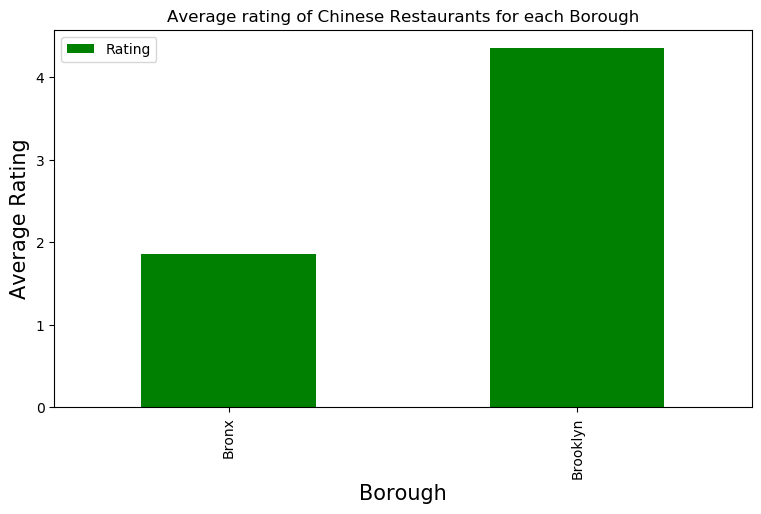

In [72]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Chinese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()


We will consider all the neighborhoods with average rating greater or equal 8.0 to visualize on a map

In [73]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Bay Ridge,7.30
3,Boerum Hill,8.10
7,Clinton Hill,7.90
9,Concourse,7.60
11,Downtown,8.50
25,North Side,9.00
28,Park Slope,7.20
31,Pelham Parkway,7.60
37,Windsor Terrace,7.45


In [74]:

ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bay Ridge,40.625801,-74.030621,7.30
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.10
2,Brooklyn,Clinton Hill,40.693229,-73.967843,7.90
3,Bronx,Concourse,40.834284,-73.915589,7.60
4,Brooklyn,Downtown,40.690844,-73.983463,8.50
5,Brooklyn,North Side,40.714823,-73.958809,9.00
6,Brooklyn,Park Slope,40.672321,-73.977050,7.20
7,Bronx,Pelham Parkway,40.857413,-73.854756,7.60
8,Brooklyn,Windsor Terrace,40.656946,-73.980073,7.45


Now we will show this data on a map

In [75]:

# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Let's add a new field to dataframe for labeling purpose

In [77]:

ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)